In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [2]:
og_df = pd.read_csv('data/Structured/data.csv')
print(og_df.shape)

(44000, 376)


In [3]:
df = og_df.dropna(axis=1, how='all')
df = df.fillna(method='ffill')
df = df.fillna(method='bfill')
for e in df.columns:
    if df[e].nunique() == 1:
        df = df.drop(e, axis=1)
# df = df.drop('SE2', axis=1)
# df = df.drop('SE3', axis=1)
df = df.drop('SE4', axis=1)
date_time = pd.to_datetime(df.pop('Date'), format='%Y.%m.%d %H:%M:%S')
df = df.loc[:, ['SE1','SE2', 'SE3']]
labels = df.loc[:,['SE1']]
# df = df.iloc[:,0:10]
print(df.shape)
print(labels.shape)
tf.convert_to_tensor(df)

(44000, 3)
(44000, 1)


<tf.Tensor: shape=(44000, 3), dtype=float64, numpy=
array([[2.5886e+02, 2.5886e+02, 2.5886e+02],
       [2.5985e+02, 2.5985e+02, 2.5985e+02],
       [2.5660e+02, 2.5660e+02, 2.5660e+02],
       ...,
       [4.7600e+01, 4.7600e+01, 4.7600e+01],
       [1.1000e-01, 1.1000e-01, 1.1000e-01],
       [2.2200e+01, 2.2200e+01, 2.2200e+01]])>

In [4]:

n = len(df)

train_df = df[0:int(n*0.7)]
train_labels = labels[0:int(n*0.7)]
# train_df = np.reshape(train_df, (1, train_df.shape[0], train_df.shape[1]))
train_df = np.reshape(np.array(train_df), (train_df.shape[0], 1, train_df.shape[1]))
# train_labels = np.reshape(train_labels, (1,train_labels.shape[0]))
print(train_df.shape)
print(train_labels.shape)
val_df = df[int(n*0.7):int(n*0.9)]
val_labels = labels[int(n*0.7):int(n*0.9)]
# val_df = np.reshape(val_df, (1, val_df.shape[0], val_df.shape[1]))
val_df = np.reshape(np.array(val_df), (val_df.shape[0], 1, val_df.shape[1]))
# val_labels = np.reshape(val_labels, (1, val_labels.shape[0]))
print(val_df.shape)
print(val_labels.shape)
test_df = df[int(n*0.9):]
test_labels = labels[int(n*0.9):]
# test_df = np.reshape(test_df, (1, test_df.shape[0], test_df.shape[1]))
test_df = np.reshape(np.array(test_df), (test_df.shape[0], 1, test_df.shape[1]))
# test_labels = np.reshape(test_labels, (1, test_labels.shape[0]))
print(test_df.shape)
print(test_labels.shape)
num_features = df.shape[1]
print(df.dtypes)


(30799, 1, 3)
(30799, 1)
(8801, 1, 3)
(8801, 1)
(4400, 1, 3)
(4400, 1)
SE1    float64
SE2    float64
SE3    float64
dtype: object


In [5]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(df)

In [6]:
model = keras.Sequential()

# Add a LSTM layer with 128 internal units.
model.add(layers.LSTM(128, return_sequences=False))

# Add a Dense layer with 10 units.
model.add(layers.Dense(num_features, kernel_initializer='zeros'))

# LSTM_model.add(layers.Reshape([1, num_features]))

print(train_df.shape)
print(train_labels.shape)

(30799, 1, 3)
(30799, 1)


In [7]:

# LSTM_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [8]:

import matplotlib.pyplot as plt
import IPython
import IPython.display
import matplotlib as mpl
class PlotLearning(tf.keras.callbacks.Callback):
    """
    Callback to plot the learning curves of the model during training.
    """
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        IPython.display.clear_output(wait=True)

        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric)
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric)
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()

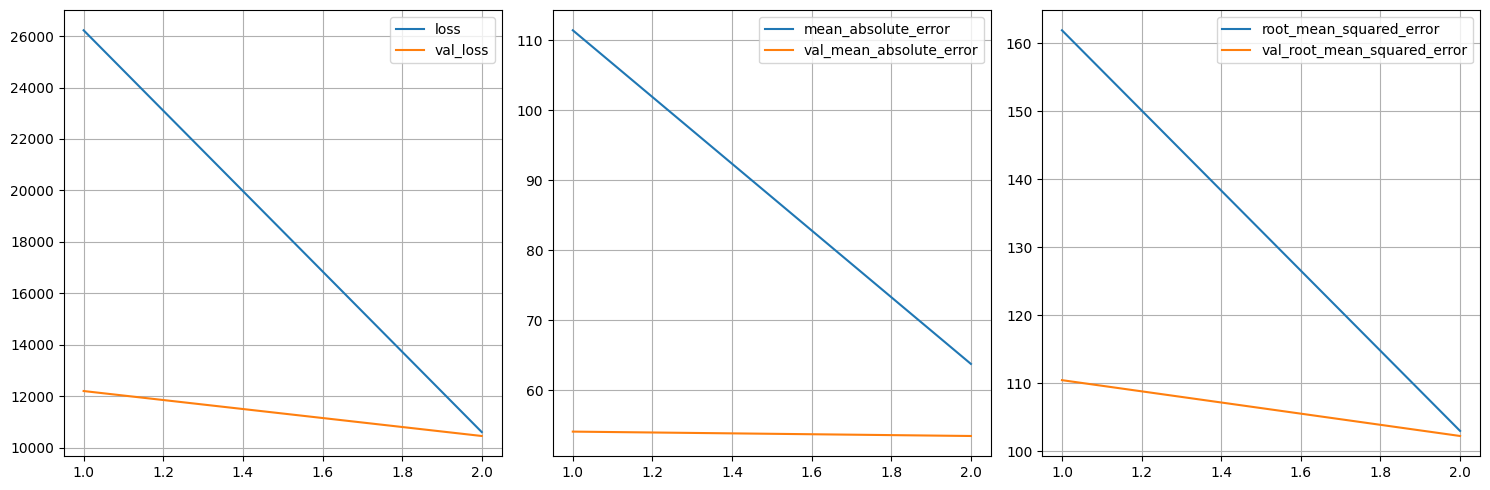

24639/24639 [==============================] - 68s 3ms/step - loss: 10607.3477 - mean_absolute_error: 63.7552 - root_mean_squared_error: 102.9921 - val_loss: 10454.8965 - val_mean_absolute_error: 53.4599 - val_root_mean_squared_error: 102.2492
Epoch 3/1000
19854/24639 [=======================>......] - ETA: 11s - loss: 10978.4199 - mean_absolute_error: 63.4050 - root_mean_squared_error: 104.7778

KeyboardInterrupt: 

In [9]:


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=5,
                                                mode='min', min_delta=0.0001)

model.compile(loss=tf.keras.losses.MeanSquaredError(),
            optimizer=tf.keras.optimizers.Adam(),
            metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.RootMeanSquaredError()])

history = model.fit(train_df, train_labels, epochs=1000, validation_split=0.2,
                    callbacks=[PlotLearning()], batch_size=1)
# LSTM_model.fit(train_df, train_labels, epochs=1000, batch_size=32, validation_split=0.2)
LSTM_model.summary()